# Machine Learning for Data Cleansing: *Building A model to predict data columns*

#### Problem statement:
Data is often recieved with varying field names and in a variety of formats . Significant human resource is required to: i) make sense of the data, and ii) transform the data to an agreed format.

#### Machine learning solution:
To build a model that can ingest messy labelled data (i.e. missing and with variable field names) and to make predctions for what the data fields are.

#### Possible applications:
Automated or bionic data cleaning systems and tools. 

* The script to recreate the data is [here]().

In [1]:
# load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import os
%matplotlib inline

## Load the training-data
 
**Fields & Formats**<BR>
The training-data has the correct headers attached. We want to predict these on inbound messy "unlabelled" data.
I have included some very generic data fields and common formats. For instance, *money* varies between text and symbol currency values and *phone* includes a variety of formats and extensions. We also have some generic text_categorical and numeric values in there.

In [3]:
training_data = pd.read_csv(os.path.join(data_path_model,'training_data.csv'))
training_data[:5]

,address1,address2,city,state,zip,lat,lng,money,reference,email,person_name,phone,first_name,last_name,txt_cat,num_cat,numeric
0,1745 T Street Southeast,NaN,Washington,DC,20020,38.867033,-76.979235,GBP 487760.350,SPCH308,mex@yahoo.com,Kimberlee Turlington,0345 42 0274,Kimberlee,Turlington,B,3,5181
1,6007 Applegate Lane,NaN,Louisville,KY,40219,38.134301,-85.649851,€ 7321963.108,VDEY870,rg@aol.com,Miguel Eveland,095086-173-31-37,Miguel,Eveland,A,4,2163
2,560 Penstock Drive,NaN,Grass Valley,CA,95945,39.213076,-121.077583,EUR 3341992.053,ZFPH671,ejbyy@hotmail.com,Alonzo Schroyer,057843 018 15-85,Alonzo,Schroyer,D,4,8193
3,150 Carter Street,NaN,Manchester,CT,6040,41.765560,-72.473091,€ 4397323.917,WMDG542,tfanfw@gmail.com,Devon Osei,0698-1368378,Devon,Osei,C,1,6134
4,2721 Lindsay Avenue,NaN,Louisville,KY,40206,38.263793,-85.700243,$ 7755233.425,SLLE128,xm@hotmail.com,Val Hoffmeyer,007 916 73 79,Val,Hoffmeyer,E,0,6663


### Reshape our training-data so that it is ready for modelling.
*Using "X", we want to predict our target variable "Y"*

In [4]:
Xy = pd.concat([pd.DataFrame(data={'X':list(training_data[col]),'Y':col}) for col in training_data.columns])
Xy.reset_index(drop=True,inplace=True)
Xy.fillna('',inplace=True) # fill nan values with empty string
Xy.sample(5)

,X,Y
24710,Dung,first_name
15162,GBP 7421858.699,money
12446,-76.9858,lng
8184,95776,zip
245,320 Northwest 22nd Street,address1


## Feature Engineering - simple
In raw text form the training-data values of X are unreadable by a computer.<BR>
We must engineer numeric representations termed features of the X values.

Here we define a function to create some generic features on our X data:
- length — The length of each string in characters
- num_length — The number of digits characters in a string
- space_length — The number of spaces within a string
- special_length — The number of special (non-alphanumeric) characters
- vowel_length - the number of vowels

In [5]:
def feat_eng(df):
    """ function to engineer basic text features """
    df['X'] = df['X'].astype(str).copy()
    df['n_chars'] = df['X'].str.len() # string length
    df['n_digits'] = df['X'].str.count(r'[0-9]') # n digits
    df['n_space'] = df['X'].str.count(r' ') # n spaces
    df['n_special'] = df['X'].str.len() - df['X'].str.count(r'[\w+ ]') # n special chars
    df['n_vowels'] = df['X'].str.count(r'(?i)[aeiou]') # n vowels
    return df.fillna(0)

Xy = feat_eng(Xy)

## Feature Engineering - advanced

Here we use a more sophisticated approach to generate numeric features on our training data. It applies a simplified version of [TF-IDF (wiki)](https://en.wikipedia.org/wiki/Tf%E2%80%93idf). TF-IDF is a statistic used to measure how unique and important a word is in the body of text. For instance, the word "and" appears in many texts and yields little information regarding the topic of the text. The word "lawsuit" is generally rarer and yields inormation about the topic of the text.  Ok so this doesnt quite apply to this case as our texts are really just single values. However, we can still use this approach to identify and label key strings in our training data. 

We can see below a sample of the output. The TF-IDF measure has identified a number of strings as *important*. These include the strings:
 - "street","road" and "ave" (subset of "avenue") related to address data.
 - currency symbols.
 - "@", ".co" and ".com" on email addresses. I'd imagine this would change our results if we added a URL field to the training data?
 - We also see that small numbers 0,1,2 are returned. This is likely due to phone numbers beginning with zero and/or [Benfords law](https://en.wikipedia.org/wiki/Benford%27s_law) of small numbers.

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(analyzer='char',
                             lowercase=True,
                             stop_words=None,
                             max_df=1.0,
                             min_df=0.005,
                             ngram_range=(1,6),
                             binary=True,
                             norm=None,
                             use_idf=False
                            )

X_vect = vectorizer.fit_transform(Xy['X'].astype(str).str.encode('utf-8'))
#print(X_vect.shape)

## test on single string
# test = vectorizer.transform(['ben@hotmail.com'])
# pd.DataFrame(data = test.todense(), columns=vectorizer.get_feature_names())

X_vect_df = pd.DataFrame(data = X_vect.todense(), columns=vectorizer.get_feature_names())
Xy_vect = Xy.merge(X_vect_df,how='left',left_index=True,right_index=True).copy()
#Xy_vect[['X','£']].loc[Xy_vect['X'].str.contains('£')==True]

In [7]:
Xy_vect.sample(5)[['X','street','road','ave','£','$','@','.co','.com','drive','0']]

,X,street,road,ave,£,$,@,.co,.com,drive,0
27454,Gural,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22112,004-570 4-61,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
22620,07 6246014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10521,38.512894,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16661,VSQO404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Feature Selection - univariate 

Ok. So that lest step actually created about 11,000 numeric features on our training data. We need to trim this down by selecting the data value features that we believe are most likley to be correlated to our target column headers. Lets use some Chi-square correlation analyses to test the features. 

**If you want to skip the stats, the bar plot below shows the 75 features that were found to have the highest correlation to our target column headers that we want to predict.**

### [Chi-squared](https://machinelearningmastery.com/chi-squared-test-for-machine-learning/)

*The chi-square test is a statistical test of independence to determine the dependency of two variables. 
It shares similarities with coefficient of determination, R².
However, chi-square test is only applicable to categorical or nominal data while R² is only applicable to numeric data.*
 - If Statistic >= Critical Value: significant result, reject null hypothesis (H0), dependent. *There **IS** a relationship*.
 - If Statistic < Critical Value: not significant result, fail to reject null hypothesis (H0), independent. *There **IS NOT** a relationship*.

In [8]:
# chi-squared test with similar proportions
from scipy.stats import chi2_contingency
from scipy.stats import chi2

prob = 0.95
alpha = 1.0 - prob

# run test
stat, p, dof, expected = chi2_contingency(pd.crosstab(Xy['Y'],Xy['n_vowels']))

# dof
print('\ndof=%d' % dof)

# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('\nprobability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('\tDependent (reject H0)')
else:
    print('\tIndependent (fail to reject H0)')
    
    
# interpret p-value
print('\nsignificance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('\tDependent (reject H0)')
else:
    print('\tIndependent (fail to reject H0)')


dof=240

probability=0.950, critical=277.138, stat=60001.619
	Dependent (reject H0)

significance=0.050, p=0.000
	Dependent (reject H0)


In [9]:
features = Xy_vect.columns[2:]
stats = list()
p_values = list()
dofs = list()

for feat in features:
    # run test
    stat, p, dof, expected = chi2_contingency(pd.crosstab(Xy_vect['Y'],Xy_vect[feat]))
    stats.append(stat)
    p_values.append(p)
    dofs.append(dof)

chi2_results = pd.DataFrame({'feature':features,'X2':stats,'DoF':dofs,'pvalue':p_values,'sig':[x<=0.05 for x in p_values]})
chi2_results.sort_values(by='X2',ascending=False, inplace=True)

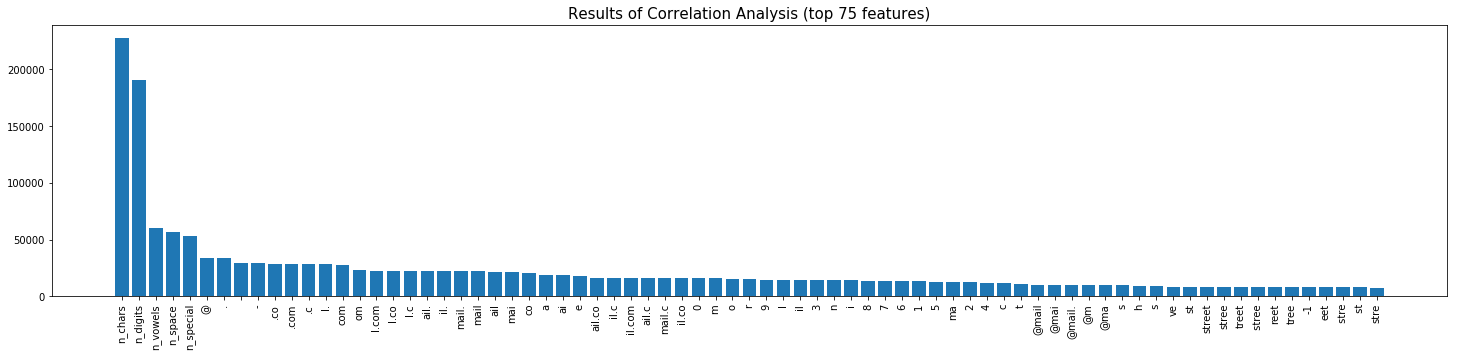

In [10]:
fig,axs = plt.subplots(figsize=(25,5))
n = 75
axs.bar(x = range(n), height=chi2_results['X2'][:n])
axs.set_xticks(range(n));
axs.set_xticklabels(chi2_results['feature'][:n],rotation=90)
axs.set_title('Results of Correlation Analysis (top 75 features)',fontsize=15);

# Model Training

Here we are building a model that can predict the column type using: i) the training data, and ii) the subset of engineered-features selected by correlation analysis.

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

In [12]:
model_features = chi2_results['feature'][:100].values

In [13]:
# model parameters
NB_params = {'model__alpha':(1e-1, 1e-3)}

NB_pipe = Pipeline([('model', MultinomialNB())])

gs_NB = GridSearchCV(NB_pipe, param_grid=NB_params, n_jobs=2, cv=5)
gs_NB = gs_NB.fit(Xy_vect[model_features], Xy_vect['Y'])
print(gs_NB.best_score_, gs_NB.best_params_)

0.7691470588235294 {'model__alpha': 0.1}


# Load Test Data
Here lets load the testing data. Note that the data is missing column headers. If we were cleaning up this data we would have to manually add these.

In [26]:
testing_data = [pd.read_csv(os.path.join(data_path_model,x),skiprows=1,header=None) for x in os.listdir(data_path_model) if 'testing' in x]
testing_data = pd.concat(testing_data)
testing_data[:10]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,11501 Maple Way,NaN,Louisville,KY,40229,38.097617,-85.659825,EUR 2274211.206,WBSW110,vmtjcbp@gmail.com,Jena Quilliams,039520 805 804,Jena,Quilliams,C,2,4795
1,98 Lee Drive,NaN,Annapolis,MD,21403,38.933313,-76.493310,EUR 3405197.530,SWLP214,hdst@gmail.com,Laila Arpin,08249 265 6568,Laila,Arpin,B,2,5021
2,126 Sunshine Road,O,Savannah,GA,31405,32.059784,-81.202271,EUR 7458286.525,VUYW948,aminwvel@yahoo.com,Cesar Severson,08-095 51-90,Cesar,Severson,A,0,5600
3,4313 Wisconsin Street,#APT 000007,Anchorage,AK,99517,61.181060,-149.942792,€ 5481056.898,SEXL728,gevypgf@mail.kz,Chi Hollinsworth,030164-378 59 20,Chi,Hollinsworth,B,1,3746
4,829 Main Street,NaN,Manchester,CT,6040,41.770678,-72.520917,GBP 4247524.506,VQZY333,yibhnaha@mail.kz,Jan Reagans,00132-612-74-32,Jan,Reagans,C,4,7541
5,37 Spring Street,NaN,Groton,CT,6340,41.320683,-71.991475,$ 5717317.815,BSRO462,lppsimxwb@mail.kz,Marcos Hoistion,018-8094-25,Marcos,Hoistion,E,3,5201
6,266 South J Street,NaN,Livermore,CA,94550,37.680570,-121.768021,$ 1921095.325,SNPX594,tgjt@aol.com,Loan Wadsworth,040 9272 23,Loan,Wadsworth,C,3,7463
7,7952 South Algonquian Way,NaN,Aurora,CO,80016,39.573350,-104.716211,$ 8932865.979,ZNNS529,snjral@aol.com,Marisa Blaskovich,087 469 8912,Marisa,Blaskovich,B,0,7738
8,9223 Elgin Circle,NaN,Anchorage,AK,99502,61.136803,-149.965463,GBP 3666134.645,ZCJN210,ebl@gmail.com,Nguyet Lytch,00748296 39 4,Nguyet,Lytch,A,1,6734
9,224 Michael Sears Road,NaN,Belchertown,MA,1007,42.234610,-72.359730,EUR 2406344.382,ZOSG574,qeaf@aol.com,Corrie Tolhurst,053601-410-69-0,Corrie,Tolhurst,D,2,1521


Below we apply the same feature engineering and selection as applied to our training data. 

In [27]:
testing_data = [pd.read_csv(os.path.join(data_path_model,x)) for x in os.listdir(data_path_model) if 'testing' in x]
testing_data = pd.concat(testing_data)
Xy_test = pd.concat([pd.DataFrame(data={'X':list(testing_data[col]),'Y':col}) for col in testing_data.columns])
Xy_test.reset_index(drop=True,inplace=True)
Xy_test.fillna('',inplace=True) # fill nan values with empty string

Xy_test = feat_eng(Xy_test)

test_vect = vectorizer.transform(Xy_test['X'].astype(str).str.encode('utf-8'))
test_vect = pd.DataFrame(data = test_vect.todense(), columns=vectorizer.get_feature_names())
Xy_test = Xy_test.merge(test_vect,how='left',left_index=True,right_index=True).copy()

### How good is the model?
Overall our model is able to correctly identify and label 77 % of the test data. Remember the model has never seen the test data before so that is pretty good. 

In [28]:
Xy_test['pred'] = gs_NB.predict(Xy_test[model_features])
print('Model accuracy: %.3f' %np.mean(Xy_test['pred'] == Xy_test['Y']))

Model accuracy: 0.774


There are also some other things we could try to improve our model further. Below we see a more detailed report and bar plot that shows us how good our model was on each data column we were trying to predict. We could for isntance, look where our model is underperfoming and try to create and select other features that better capture the data fields. 

[See this guide for interpretation of accuracy, precision, recall etc..](https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/)

In [29]:
print(metrics.classification_report(Xy_test['Y'], Xy_test['pred']))

              precision    recall  f1-score   support

    address1       0.53      0.99      0.69      1220
    address2       0.86      0.08      0.14      1220
        city       0.64      0.56      0.60      1220
       email       1.00      1.00      1.00      1220
  first_name       0.46      0.51      0.48      1220
   last_name       0.51      0.46      0.49      1220
         lat       0.98      1.00      0.99      1220
         lng       0.88      1.00      0.94      1220
       money       1.00      1.00      1.00      1220
     num_cat       0.82      1.00      0.90      1220
     numeric       0.70      0.68      0.69      1220
 person_name       0.88      0.98      0.92      1220
       phone       0.99      0.85      0.91      1220
   reference       1.00      0.96      0.98      1220
       state       0.80      0.50      0.61      1220
     txt_cat       0.74      1.00      0.85      1220
         zip       0.68      0.59      0.63      1220

   micro avg       0.77   

**The bar charts below show the distribution of predictions for each target.**

For instance:
 - **address1**: the model was able to identify all of the address1 values in the testing data. 
 - **city**: The model indentified roughly 50% of the correct city values, but often confused these with human names.

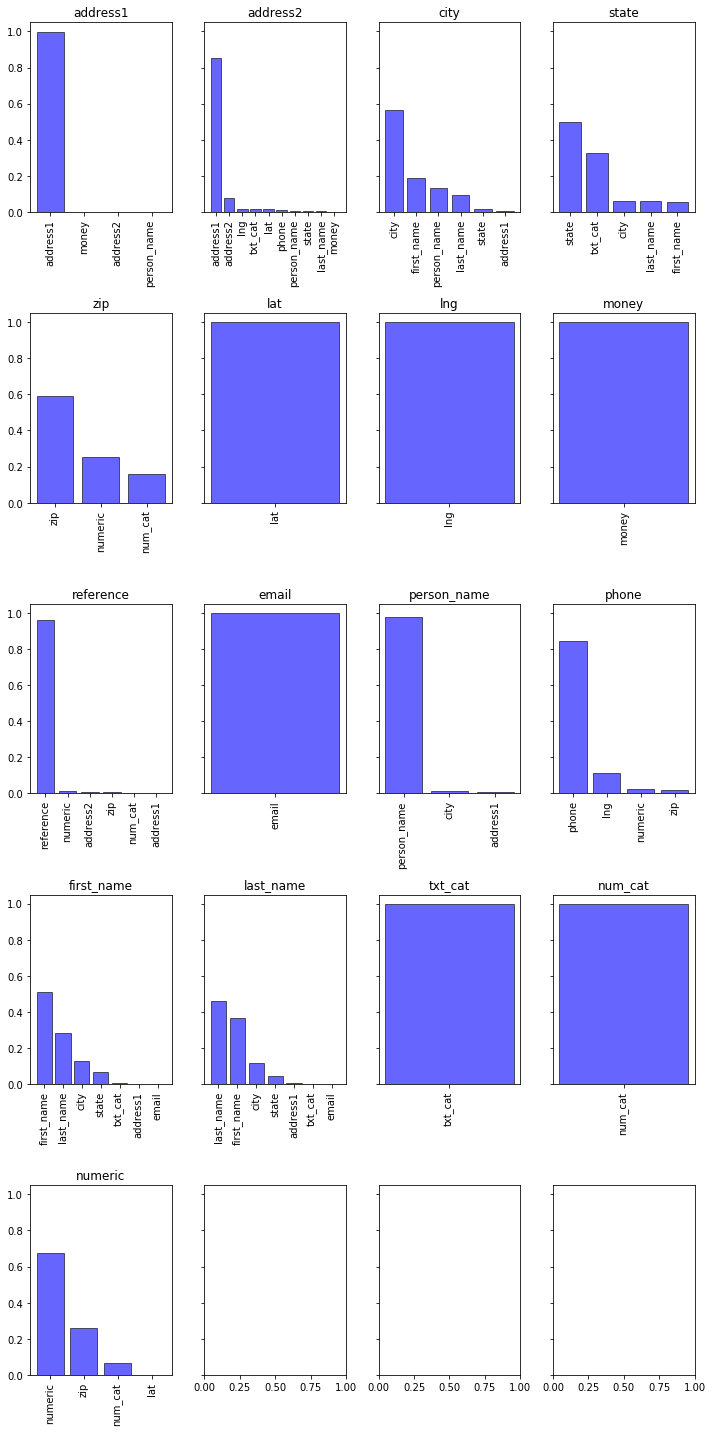

In [30]:
fig,axs = plt.subplots(5,4,figsize=(10,20),sharey=True)

for target,ax in zip(Xy_test['Y'].unique(),axs.flatten()):
    heights = Xy_test.loc[Xy_test['Y']==target,'pred'].value_counts()
    x = range(len(heights))
    ax.bar(x=x,height=heights/1220,color='blue',edgecolor='black',alpha=0.6)
    ax.set_xticks(x)
    ax.set_xticklabels(heights.index,rotation=90)
    ax.set_title(target)
    
plt.tight_layout()

Thats all folks.<BR>
Thank you for reading.

Ben Postance